# Разработка A/B-тестирования и анализ результатов

## Введение

В приложении с функцией «бесконечной» ленты существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Гипотеза: новый алгоритм рекомендаций будет показывать более интересный контент для каждого пользователя. Необходимо рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

### Цели и задачи проекта
Рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### Описание данных

Датасеты, которые понадобятся в проекте::

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23.
- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14.
- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. 

У таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;
- `session_id` — идентификатор сессии в приложении;
- `session_date` — дата сессии;
- `session_start_ts` — дата и время начала сессии;
- `install_date` — дата установки приложения;
- `session_number` — порядковый номер сессии для конкретного пользователя;
- `registration_flag` — является ли пользователь зарегистрированным;
- `page_counter` — количество просмотренных страниц во время сессии;
- `region` — регион пользователя;
- `device` — тип устройства пользователя;
- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).

## Работа с историческими данными (EDA)

### Загрузка исторических данных
- Импортируем необходимые для работы библиотеки.
- Считаем и сохраним в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

In [1]:
# Загружаем все библиотеки необходимые для работы
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from scipy import stats as st
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportions_ztest

In [2]:
df_sessions_history = pd.read_csv('https://.../sessions_project_history.csv')

In [3]:
df_sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


### Знакомство с данными
1. Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.
2. Выведем на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберем любого из них.
3. Изучим таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.

In [4]:
# Найдем пользователя с максимальным количеством сессий
max_user_id = df_sessions_history['user_id'].value_counts().idxmax()

# Выведем инфомрацию о пользователе
df_sessions_history[df_sessions_history['user_id'] == max_user_id]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
124515,6A73CB5566BB494D,110E3F28C1F5415F,2025-08-28,2025-08-28 18:58:19,2025-08-28,1,0,3,MENA,Mac
196252,6A73CB5566BB494D,D68C8D98A0F1C439,2025-08-29,2025-08-29 20:53:27,2025-08-28,2,1,3,MENA,Mac
242428,6A73CB5566BB494D,6587D217472BF807,2025-08-30,2025-08-30 13:08:22,2025-08-28,3,1,1,MENA,Mac
304287,6A73CB5566BB494D,A9BC25593D056F8E,2025-09-01,2025-09-01 18:52:49,2025-08-28,4,1,2,MENA,Mac
346611,6A73CB5566BB494D,CB6F9C4191FAF6F6,2025-09-03,2025-09-03 22:49:08,2025-08-28,5,1,3,MENA,Mac
363510,6A73CB5566BB494D,9C609432F6E6535A,2025-09-04,2025-09-04 13:59:46,2025-08-28,6,1,4,MENA,Mac
391902,6A73CB5566BB494D,5D892E33B97A257A,2025-09-06,2025-09-06 18:46:55,2025-08-28,7,1,2,MENA,Mac
404322,6A73CB5566BB494D,22A9BD3861F49087,2025-09-07,2025-09-07 18:33:49,2025-08-28,8,1,3,MENA,Mac
415489,6A73CB5566BB494D,F70E351154B092DC,2025-09-08,2025-09-08 20:30:22,2025-08-28,9,1,4,MENA,Mac
425805,6A73CB5566BB494D,84A3DC0CFF449F53,2025-09-09,2025-09-09 16:36:04,2025-08-28,10,1,1,MENA,Mac


### Анализ числа регистраций
Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.

1. Агрегируем исторические данные и рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считаем, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.
2. Построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. 
3. Построим отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

In [5]:
# Рассчитаем количество всех пользователей
cnt_all_users = df_sessions_history.groupby('session_date').agg(all_users=('user_id', 'nunique'))

# Рассчитаем количество зарегистрированных пользователей
cnt_reg_users = df_sessions_history[df_sessions_history['registration_flag'] == 1].groupby('session_date').agg(
    reg_users=('user_id', 'nunique'))

# Объединим таблицы
df_cnt_users = pd.merge(cnt_all_users, cnt_reg_users, on='session_date', how='inner')

df_cnt_users.head()

,all_users,reg_users
session_date,,
2025-08-11,3919,169
2025-08-12,6056,336
2025-08-13,8489,464
2025-08-14,10321,625
2025-08-15,14065,840


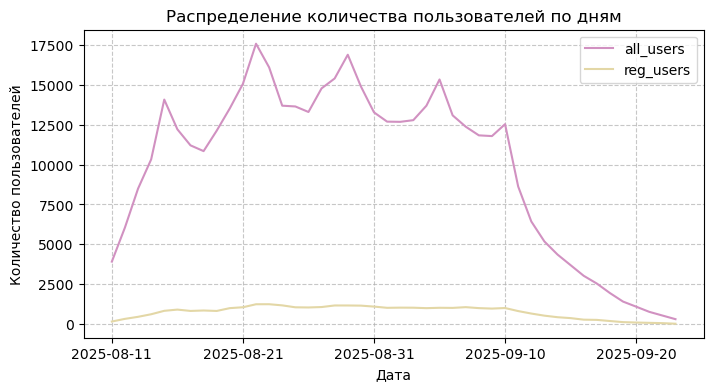

In [6]:
type_users_colors = ['#d191c1', '#e3d7a6']

df_cnt_users.plot.line(figsize=(8, 4), color=type_users_colors)

plt.title('Распределение количества пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [7]:
# Рассчитаем долю зарегистрированных пользователей от всех пользователей по дням
df_cnt_users['users_share'] = df_cnt_users['reg_users'] / df_cnt_users['all_users']
df_cnt_users.head()

,all_users,reg_users,users_share
session_date,,,
2025-08-11,3919,169,0.043123
2025-08-12,6056,336,0.055482
2025-08-13,8489,464,0.054659
2025-08-14,10321,625,0.060556
2025-08-15,14065,840,0.059723


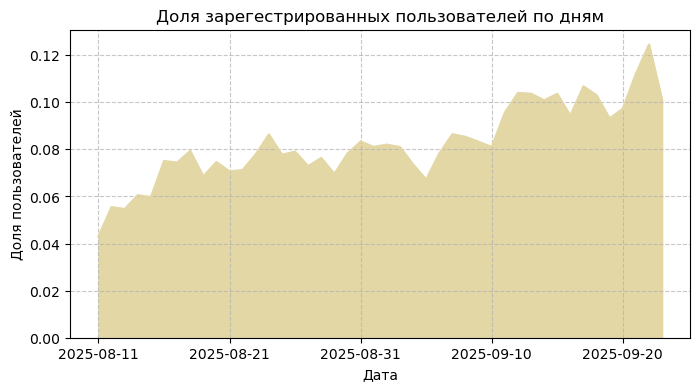

In [8]:
df_cnt_users.plot(kind='area',
                  figsize=(8, 4),
                  y='users_share',
                  color='#e3d7a6',
                  legend=False)

plt.title('Доля зарегестрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Доля пользователей')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

#### Промежуточный вывод
На графике количества пользователей в день:
- в период с 2025-08-11	по 2025-08-29 наблюдается рост числа посетителей, пик достигается 2025-08-29 составляет 16873, после чего идет медленный спад числа посетителей вплоть до окончания наблюдаемого периода.
- в период с 2025-08-11 по 2025-08-28 наблюдается рост числа зарегистрированных посетителей, пик достигается 2025-08-28 составляет 1175, после чего идет медленный спад числа посетителей вплоть до окончания наблюдаемого периода.

В период с 2025-08-11 по 2025-09-23 наблюдается рост доли зарегистрированных пользователей. При этом в 2025-08-29некоторые период наблюдается существенный спад регистраций:
- 5	сентября, доля регистрации: 0.067215. 
- с 19, 20 сентября, доля регистраций: 0.093089, 0.097273.

Общий тренд доли зарегистрированных пользователей возрастающий.

---


### Анализ числа просмотренных страниц

1. Найдём количество сессий для каждого значения количества просмотренных страниц. 
2. Построим столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

In [9]:
cnt_session = df_sessions_history.groupby('page_counter').agg(count_session = ('session_id','nunique'))
cnt_session

,count_session
page_counter,
1,29160
2,105536
3,166690
4,105569
5,26288
6,2589
7,92


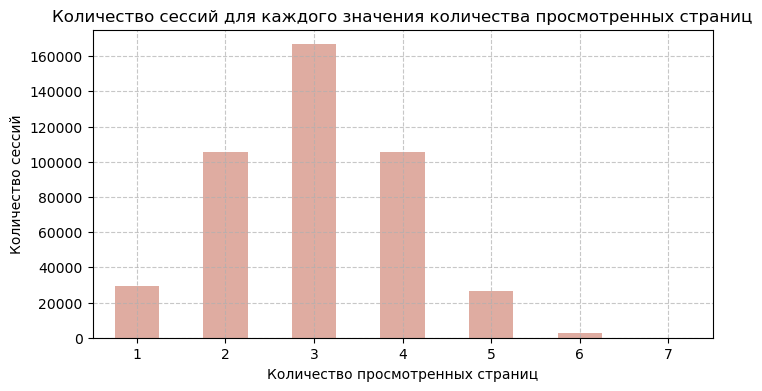

In [10]:
cnt_session.plot.bar(rot=0, 
                     figsize=(8, 4), 
                     legend=False,
                     color='#dfaca1')

plt.grid(True, linestyle='--', alpha=0.7)

plt.title('Количество сессий для каждого значения количества просмотренных страниц')
plt.xlabel('Количество просмотренных страниц')
plt.ylabel('Количество сессий')
plt.show()

### Доля пользователей, просмотревших более четырёх страниц

1. В датафрейме `sessions_history` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.
2. Построим график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

In [11]:
df_sessions_history['good_session'] = df_sessions_history['page_counter'].apply(lambda x: 1 if x >= 4 else 0)

In [12]:
cnt_good_sessions = df_sessions_history[df_sessions_history['good_session'] == 1].groupby('session_date').agg(
    good_sessions=('session_id', 'nunique'))

cnt_all_sessions = df_sessions_history.groupby('session_date').agg(
    all_sessions=('session_id', 'nunique'))

count_sessions = pd.merge(cnt_good_sessions, cnt_all_sessions, on='session_date', how='inner')
count_sessions['share'] = count_sessions['good_sessions'] / count_sessions['all_sessions']
count_sessions = count_sessions.reset_index()

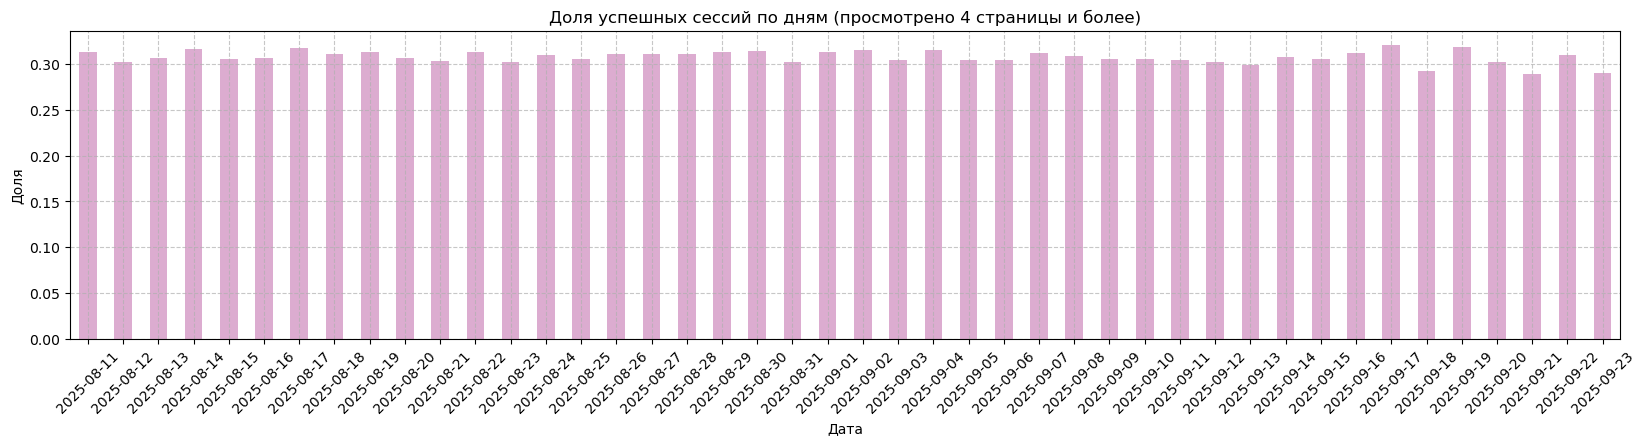

In [13]:
count_sessions.plot.bar(figsize=(20, 4), 
                         x='session_date', 
                         y='share',
                         legend=False,
                         rot=45,
                         color='#d191c1',
                         alpha=0.75)

plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Доля успешных сессий по дням (просмотрено 4 страницы и более)')
plt.xlabel('Дата')
plt.ylabel('Доля')

plt.show()

Чтобы на графике были лучше видны изменения доли успешных сессий, зададим нижний и верхний предел оси y.

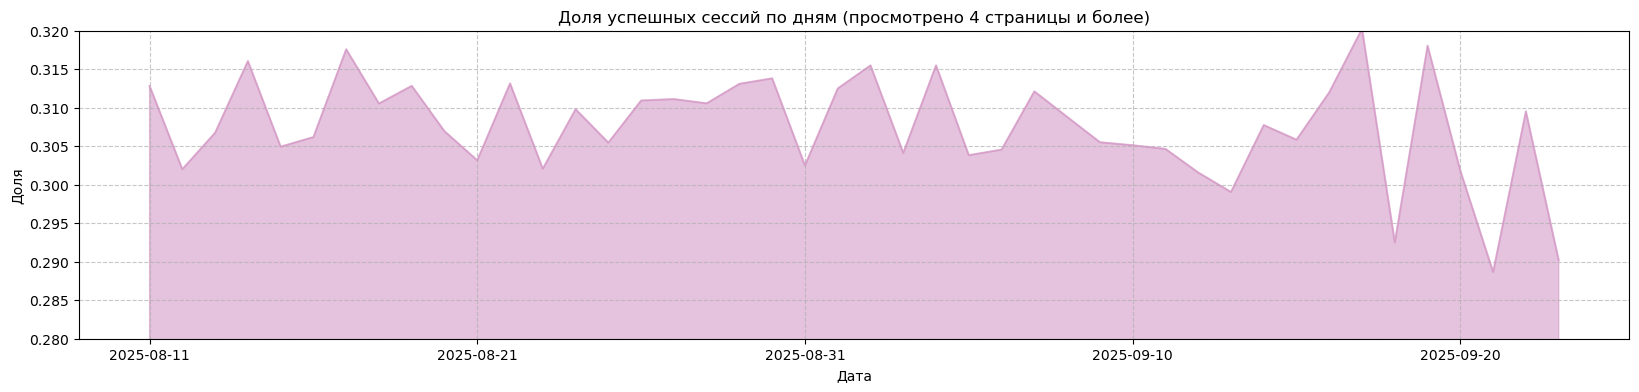

In [14]:
count_sessions.plot(figsize=(20, 4),
                    kind='area',
                         x='session_date', 
                         y='share',
                         legend=False,
                         rot=0,
                         color='#d191c1',
                         alpha=0.55)

plt.ylim(0.28, 0.32)

plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Доля успешных сессий по дням (просмотрено 4 страницы и более)')
plt.xlabel('Дата')
plt.ylabel('Доля')

plt.show()

## Подготовка к тесту

1. Определим с целевую метрику.
2. Рассчитаем необходимый размер выборки.
3. Исходя из текущих значений трафика, рассчитаем необходимую длительность проведения теста.

### Расчёт размера выборки
Рассчитаем необходимое для дизайна эксперимента количество пользователей.

Параметры:

- Уровень значимости — 0.05.
- Вероятность ошибки второго рода — 0.2.
- Мощность теста.
- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

In [15]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


### Расчёт длительности A/B-теста

Используя данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения, рассчитаем длительность теста, разделив одно на другое.

1. Рассчитаем среднее количество уникальных пользователей приложения в день.
2. Определим длительность теста, исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлим в большую сторону.

In [16]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = round((df_sessions_history.groupby('session_date')['user_id'].count()).mean())

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size * 2 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дня.")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 4 дня.


## Мониторинг А/В-теста

### Проверка распределения пользователей

Проанализируем данные теста за первые три дня. Убедимся, что начальный этап теста прошел хорошо: пользователи разделены правильным образом, а интересующие нас метрики корректно считаются.

1. Считаем и сохраним в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.
2. Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.
3. Рассчитаем и выведем на экран процентную разницу в количестве пользователей в группах A и B. 

Для расчёта процентной разницы воспользуемся формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [17]:
# Считаем и сохраним в датафрейм sessions_test_part исторические данными о сессиях пользователей 
try:
    sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')
except ZeroDivisionError:
    print('Something is wrong')
else:
    print("Операция выполнена успешно.")

Операция выполнена успешно.


In [18]:
# Создадим отдельные группы
group_A = sessions_test_part[sessions_test_part['test_group'] == 'A']
group_B = sessions_test_part[sessions_test_part['test_group'] == 'B']

In [19]:
# Рассчитем количество пользователей в каждой группе
a_cnt_users = group_A['user_id'].nunique()
b_cnt_users = group_B['user_id'].nunique()
print(f'Количество пользователей в группе A: {a_cnt_users}')
print(f'Количество пользователей в группе B: {b_cnt_users}')

Количество пользователей в группе A: 1477
Количество пользователей в группе B: 1466


In [20]:
# Рассчитем процентную разницу в количестве пользователей
P = round((a_cnt_users - b_cnt_users) / a_cnt_users * 100, 2)
print(f'Процентная разница в количестве пользователей = {P}')

Процентная разница в количестве пользователей = 0.74


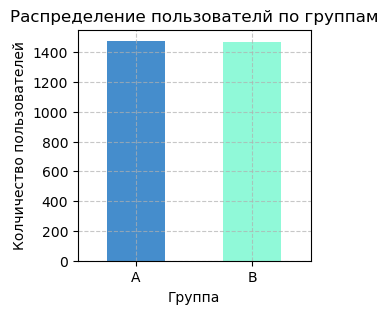

In [21]:
users_per_group = sessions_test_part.groupby('test_group', as_index=False).agg(cnt_users = ('user_id', 'nunique'))

groups_colors = ['#458dcc', '#90f9d8']

users_per_group.plot.bar(figsize=(3,3),
                         legend=False,
                         rot=0,
                         x='test_group',
                         y='cnt_users',
                         color=groups_colors)

plt.grid(True, linestyle='--', alpha=0.7)

plt.title('Распределение пользователй по группам')
plt.xlabel('Группа')
plt.ylabel('Колчичество пользователей')
plt.show()

### Проверка пересечений пользователей
Убедимся в том, что группы независимы. Проверим, что никто из пользователей случайно не попал в обе группы одновременно. Для этого рассчитаем количество пользователей, которые встречаются одновременно в группах A и B, или убедимся, что таких нет.

In [22]:
# Найдем пользователей, которые встречаются в обеих группах и выведим их id
intersection = sessions_test_part.groupby('user_id').agg({'test_group': 'nunique'}).query('test_group > 1')
intersection

,test_group
user_id,


Пересечения пользователей в группах не выявлено.

### Равномерность разделения пользователей по устройствам
Убедимся, что пользователи равномерно распределены по типам устройств. Для этого построим диаграмму с долями каждого типа устройства для пользователей из групп A и B.

In [23]:
# Посчитаем количество устройств по тимам для каждой группы
devices_gr_a = group_A.groupby('device', as_index=False).agg(group_a = ('user_id', 'nunique'))
devices_gr_b = group_B.groupby('device', as_index=False).agg(group_b = ('user_id', 'nunique'))

# Расчитаем процент устройств по типа для каждой группы
devices_gr_a['group_a'] = round(devices_gr_a['group_a'] / a_cnt_users * 100) 
devices_gr_b['group_b'] = round(devices_gr_b['group_b'] / b_cnt_users * 100) 

# Объединим полученные значения
merget_per_devices = devices_gr_a.merge(devices_gr_b, on='device')
merget_per_devices

,device,group_a,group_b
0,Android,44.0,46.0
1,Mac,11.0,10.0
2,PC,25.0,26.0
3,iPhone,20.0,18.0


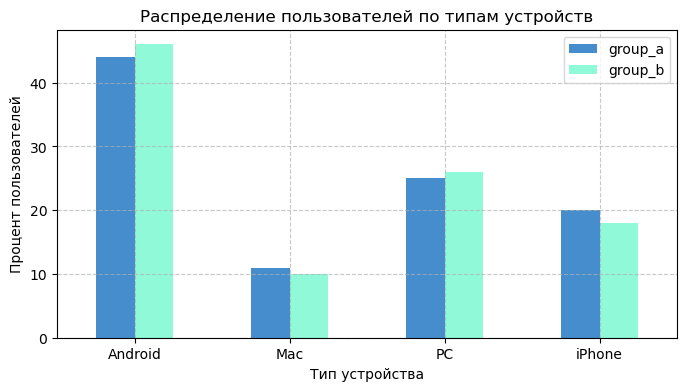

In [24]:
colors = ['#4ec6cc', '#94e08d']

merget_per_devices.plot.bar(figsize = (8, 4),
                x='device',
                rot = 0,
                legend=True,
                color=groups_colors)

plt.grid(True, linestyle='--', alpha=0.7)

plt.title('Распределение пользователей по типам устройств')
plt.xlabel('Тип устройства')
plt.ylabel('Процент пользователей')

plt.show()

Пользователи равномерно распределены по типам утройств для каждой группы.

### Равномерность распределения пользователей по регионам
Убедимся, что пользователи равномерно распределены по регионам. Для этого построим диаграмму с долей каждого региона для пользователей из групп A и B.

In [25]:
# Рассчитаем кол-во пользователей для каждого региона по группам
region_gr_a = group_A.groupby('region', as_index=False).agg(reg_group_a = ('user_id', 'nunique'))
region_gr_b = group_B.groupby('region', as_index=False).agg(reg_group_b = ('user_id', 'nunique'))

# Расчитаем распределение по регионам для каждой группы
region_gr_a['reg_group_a'] = round(region_gr_a['reg_group_a'] / a_cnt_users * 100, 2) 
region_gr_b['reg_group_b'] = round(region_gr_b['reg_group_b'] / b_cnt_users * 100, 2) 

In [26]:
# Объединим полученные значения
merget_per_region = region_gr_a.merge(region_gr_b, on='region')
merget_per_region

,region,reg_group_a,reg_group_b
0,CIS,43.60,44.0
1,EU,15.17,14.8
2,MENA,41.23,41.2


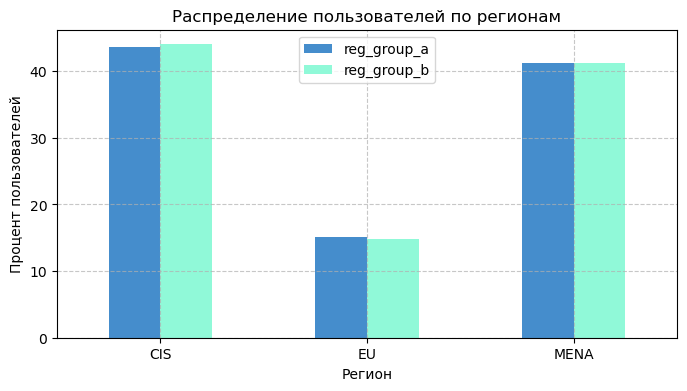

In [27]:
colors = ['#4ec6cc', '#94e08d']

merget_per_region.plot.bar(figsize = (8, 4),
                x='region',
                rot = 0,
                legend=True,
                color=groups_colors)

plt.grid(True, linestyle='--', alpha=0.7)

plt.title('Распределение пользователей по регионам')
plt.xlabel('Регион')
plt.ylabel('Процент пользователей')

plt.show()

Пользователи равномерно распределены по регионам для каждой группы.

#### Промежуточный вывод

- Процентная разница в количестве пользователей несущественна и равна 0.74. Количество пользователей в группах A и B составляет 1477 и 1466. Различие в количестве пользователей в двух группах не обнаружено.
- Выборки являются независимыми. Пересечение пользователей из тестовой и контрольной групп не обнаружено.
- Равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам сохраняестя.

**A/B-тест проходит корректно, нарушения не наблюдаются.**

## Проверка результатов A/B-теста

Изучим данные A/B-теста после его завершения. Убедимся в корректности теста и интерпретируем результаты.

### Получение результатов теста и подсчёт основной метрики

1. Считаем и сохраним в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.
2. В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [28]:
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

In [29]:
sessions_test['good_session'] = sessions_test['page_counter'].apply(lambda x: 1 if x >= 4 else 0)

### Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, убедимся, что тест проведён корректно и мы будем сравнивать две сопоставимые группы.

1. Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.
2. Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Для этого используем статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

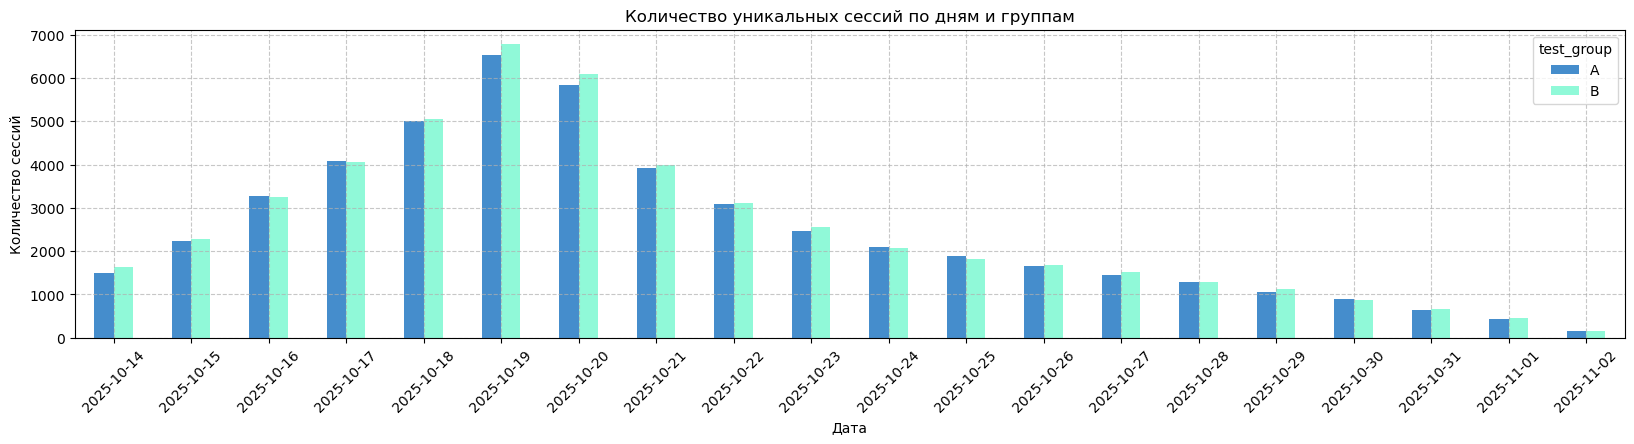

In [30]:
# Количество уникальных сессий для каждого дня
grouped = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().unstack(fill_value=0)

colors = ['#4ec6cc', '#94e08d']

grouped.plot.bar(figsize = (20, 4),
                 rot = 45,
                 legend=True,
                 color=groups_colors)

plt.grid(True, linestyle='--', alpha=0.7)

plt.title('Количество уникальных сессий по дням и группам')
plt.xlabel('Дата')
plt.ylabel('Количество сессий')

plt.show()

**Формулировка гипотезы с двумя выборками.**

Нулевая гипотеза $H_0: \rho_{\text{A}} = \rho_{\text{B}}$ <br> Количество уникальных дневных сессий **не различается** между тестовой и контрольной группами.

Альтернативная гипотеза $H_1: \rho_{\text{A}} < \rho_{\text{B}}$ <br> Кол-во уникальных дневных сессий в двух выборках **различается**, и это различие статистически значимо.

In [31]:
session_per_day_A = sessions_test[sessions_test['test_group'] == 'A'].groupby('session_date')['session_id'].nunique()
session_per_day_B = sessions_test[sessions_test['test_group'] == 'B'].groupby('session_date')['session_id'].nunique()

alpha = 0.05

results = st.ttest_ind(session_per_day_A,
                       session_per_day_B,
                       alternative = 'two-sided')

if results.pvalue > alpha:
    print(f'p-значение: {round(results.pvalue, 2)}')
    print('Нулевая гипотеза находит подтверждение! Количество уникальных дневных сессий в двух выборках не различается.')
else:
    print(f'p-значение: {round(results.pvalue, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Кол-во уникальных дневных сессий в двух выборках различается, и это различие статистически значимо.')

p-значение: 0.94
Нулевая гипотеза находит подтверждение! Количество уникальных дневных сессий в двух выборках не различается.


### Сравнение доли успешных сессий

Так как мы убедились, что количество сессий в обеих выборках не различалось, перейдем к анализу ключевой метрики — доли успешных сессий. Используем созданный на первом шаге столбец `good_session` и рассчитаем долю успешных сессий для выборок A и B, а также разницу в этом показателе.

In [32]:
# Фильтрация данных для гурппы A
group_A = sessions_test[sessions_test['test_group'] == 'A']

# Кол-во уникальных сессий
all_session_A = group_A['session_id'].nunique()

# Кол-во успешных(кол-во просмотренных страниц > 4) сессий
good_session_A = group_A.loc[sessions_test['good_session'] == 1]['session_id'].nunique()

# Доля успешных сессий
share_A = good_session_A / all_session_A * 100
print(f'Доля успешных сессий в группе А: {share_A}')

Доля успешных сессий в группе А: 30.772335573449578


In [33]:
# Фильтрация данных для гурппы B
group_B = sessions_test[sessions_test['test_group'] == 'B']

# Кол-во уникальных сессий 
all_session_B = group_B['session_id'].nunique()

# Кол-во успешных(кол-во просмотренных страниц > 4) сессий
good_session_B = group_B.loc[sessions_test['good_session'] == 1]['session_id'].nunique()

# Доля успешных сессий
share_B = good_session_B / all_session_B * 100
print(f'Доля успешных сессий в группе B: {share_B}')

Доля успешных сессий в группе B: 31.828992745867524


In [34]:
dif = round(share_B - share_A)
print(f'Количество успешных сессий в тестовой выборке примерно на {dif} % выше, чем в контрольной.')

Количество успешных сессий в тестовой выборке примерно на 1 % выше, чем в контрольной.


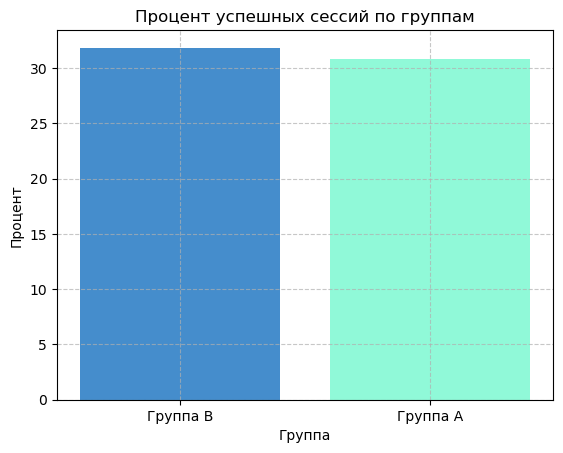

In [35]:
group = ['Группа В', 'Группа А']
share = [share_B, share_A]

colors = groups_colors

plt.bar(group, share, color=colors)

plt.grid(True, linestyle='--', alpha=0.7)

plt.title('Процент успешных сессий по группам')
plt.xlabel('Группа')
plt.ylabel('Процент')

plt.show()

### Промежуточный вывод

Сравнение доли успешных сессий — важный шаг, потому что именно эта метрика показывает, насколько эффективно пользователи достигают целевого действия при взаимодействии с продуктом.

Если доля успешных сессий в одной из групп выше, это может говорить о том, что изменения, протестированные в этой группе, положительно повлияли на пользовательский опыт. А значит, они могут быть внедрены в основную версию продукта.

Без такой проверки невозможно оценить реальное влияние нововведения — даже если распределение сессий по группам было корректным.

### Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге мы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

1. Используя статистический тест, рассчитаем, является ли изменение в метрике доли успешных сессий статистически значимым.
2. Выведем на экран полученное значение p-value и выводы о статистической значимости.

**Формулировка гипотезы с двумя выборками.**

Так как нам необходимо определить является ли изменение в метрике доли успешных сессий статистически значимым воспользуемся Z-тестом пропорций.

Необходимо определить увеличилась ли доля успешных сессий (кол-во просмотренных страниц 4 и более) после внедрения нового  алгоритма рекомендаций в контрольной выборке (группа В) или нет.

**Дано**
- μA — метрика в **тестовой группе**. Это группа, на которой проводится эксперимент или изменение. У нас это B.
- μB — метрика в **контрольной группе**. Это группа, которая не подвергается изменению. Она служит для сравнения, чтобы понять, как изменение в тестовой группе повлияло на результаты. У нас это A.

**Формулировка гипотезы**

Нулевая гипотеза H₀: μA ≤ μB <br> Количество успешных сессий в тестовой выборке (группа А) **не отличается** от количества сессий в контрольной выборке (группа В).

Альтернативная гипотеза H₁: μA > μB <br> Количество успешных сессий в контрольной выборке (группа В) **больше**, чем в тестовой выборке (группа А), и это различие статистически значимо.

In [36]:
# Размер выборки
n_a = all_session_B # Тестовая группа
n_b = all_session_A # Контрольная группа

# Кол-во успехов в групах a и b 
m_a = good_session_B # Тестовая группа
m_b = good_session_A # Контрольная группа

# Доли
p_a, p_b = m_a/n_a, m_b/n_b

print(f'n_a={n_a}, n_b={n_b}')

print(f'm_a={m_a}, m_b={m_b}')

print(f'p_a={p_a}, p_b={p_b}')

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

n_a=50454, n_b=49551
m_a=16059, m_b=15248
p_a=0.31828992745867524, p_b=0.3077233557344958
Предпосылка о достаточном количестве данных выполняется!


In [37]:
alpha = 0.05

stat_ztest, p_value_ztest = proportions_ztest (
    [m_a, m_b],
    [n_a, n_b],
    alternative='larger'
)

print(f'p-value = {p_value_ztest}')

if p_value_ztest > alpha:
    print(f'pvalue = {p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение! Доли успешных сессий в контрольной (группа А) и тестовой (группа В) группах не различаются.')
else:
    print(f'pvalue = {p_value_ztest} < {alpha}')
    print()
    print('Нулевая гипотеза не находит подтверждения! Доля успешных сессий в тестовой группе (группа В) больше, чем в контрольной (группа А), и это различие существенно.')
    print('При внедрении нового алгоритма рекомендаций, доля успешных сессий в тестовой группе уеличилась.')

p-value = 0.0001574739988036123
pvalue = 0.0001574739988036123 < 0.05

Нулевая гипотеза не находит подтверждения! Доля успешных сессий в тестовой группе (группа В) больше, чем в контрольной (группа А), и это различие существенно.
При внедрении нового алгоритма рекомендаций, доля успешных сессий в тестовой группе уеличилась.


#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять новоовведение в приложение.

#### Выводы

- Количество задействованных пользователей для каждой группы 17441.
- Длительность эксперимента при текущем уровене трафика в 9907 пользователей в день - составила 4 дня.
- Значение p-value = 0.0001574739988036123.

Ключевая метрика (доля сессий, где просмотрено 4 страницы и более) выросла примерно на 1.1%.

**Так как при внедрении нового алгоритма рекомендаций, доля успешных сессий в тестовой группе уеличилась — нововведение в приложение стоит внедрить.**